In [11]:
import kagglehub

# download the dataset "Students' AI Usage and Academic Performance"
path = kagglehub.dataset_download("aminasalamt/students-ai-usage-and-academic-performance")

print("Path to dataset files:", path)

Path to dataset files: /Users/meganvaughn/.cache/kagglehub/datasets/aminasalamt/students-ai-usage-and-academic-performance/versions/1


In [12]:
# imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, classification_report

from pathlib import Path

In [13]:
# load and inspect data
data_dir = Path(path)
csv_path = data_dir / "students_ai_usage.csv"

df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

df.head()

,age,education_level,study_hours_per_day,uses_ai,ai_tools_used,purpose_of_ai,grades_before_ai,grades_after_ai,daily_screen_time_hours
0,19,college,1.4,No,NaN,NaN,62,62,3
1,15,school,3.9,Yes,Copilot,Research,56,61,2
2,15,school,1.9,Yes,Copilot,Homework,75,88,5
3,15,school,2.8,No,NaN,NaN,55,55,3
4,19,college,2.7,No,NaN,NaN,59,59,3


In [14]:
# data cleaning
df.info()

def normalize_yes_no(x):
    if pd.isna(x):
        return "No"
    s = str(x).strip().lower()
    if s in {"yes", "true", "1", "y"}:
        return "Yes"
    if s in {"no", "false", "0", "n"}:
        return "No"
    return str(x).title()

df["uses_ai"] = df["uses_ai"].apply(normalize_yes_no)

for col in ["education_level", "ai_tools_used", "purpose_of_ai"]:
    df[col] = df[col].fillna("None").astype(str)

num_cols = [
    "age",
    "study_hours_per_day",
    "grades_before_ai",
    "grades_after_ai",
    "daily_screen_time_hours"
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      100 non-null    int64  
 1   education_level          100 non-null    object 
 2   study_hours_per_day      100 non-null    float64
 3   uses_ai                  100 non-null    object 
 4   ai_tools_used            40 non-null     object 
 5   purpose_of_ai            40 non-null     object 
 6   grades_before_ai         100 non-null    int64  
 7   grades_after_ai          100 non-null    int64  
 8   daily_screen_time_hours  100 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 7.2+ KB


age                        0
education_level            0
study_hours_per_day        0
uses_ai                    0
ai_tools_used              0
purpose_of_ai              0
grades_before_ai           0
grades_after_ai            0
daily_screen_time_hours    0
dtype: int64

In [15]:
# feature engineering
df["grade_change"] = df["grades_after_ai"] - df["grades_before_ai"]
df["improved"] = (df["grade_change"] > 0).astype(int)

df[[
    "uses_ai",
    "ai_tools_used",
    "purpose_of_ai",
    "grades_before_ai",
    "grades_after_ai",
    "grade_change",
    "improved"
]].head()

,uses_ai,ai_tools_used,purpose_of_ai,grades_before_ai,grades_after_ai,grade_change,improved
0,No,None,None,62,62,0,0
1,Yes,Copilot,Research,56,61,5,1
2,Yes,Copilot,Homework,75,88,13,1
3,No,None,None,55,55,0,0
4,No,None,None,59,59,0,0


In [16]:
# descriptive statistics
summary = df.describe(include="all").transpose()
summary

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,100.0,NaN,NaN,NaN,16.49,1.702612,14.0,15.0,16.0,18.0,19.0
education_level,100,2,school,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
study_hours_per_day,100.0,NaN,NaN,NaN,2.987,1.145713,1.0,1.975,2.8,4.025,5.0
uses_ai,100,2,No,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ai_tools_used,100,4,None,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purpose_of_ai,100,4,None,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
grades_before_ai,100.0,NaN,NaN,NaN,64.77,6.16909,55.0,59.0,63.0,70.0,75.0
grades_after_ai,100.0,NaN,NaN,NaN,68.7,8.140806,55.0,61.0,69.0,74.0,89.0
daily_screen_time_hours,100.0,NaN,NaN,NaN,4.34,1.793479,2.0,3.0,4.0,6.0,7.0
grade_change,100.0,NaN,NaN,NaN,3.93,5.326236,0.0,0.0,0.0,8.0,15.0


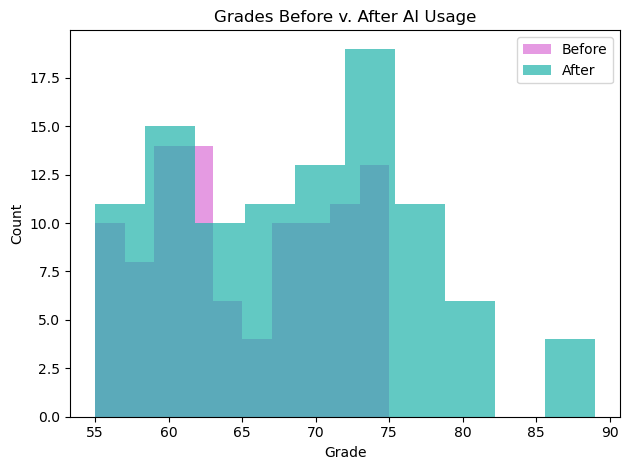

In [17]:
# grades before and after AI usage
plt.figure()
plt.hist(df["grades_before_ai"], bins=10, alpha=0.7, label="Before", color = "orchid")
plt.hist(df["grades_after_ai"], bins=10, alpha=0.7, label="After", color = "lightseagreen")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.title("Grades Before v. After AI Usage")
plt.legend()
plt.tight_layout()
plt.show()

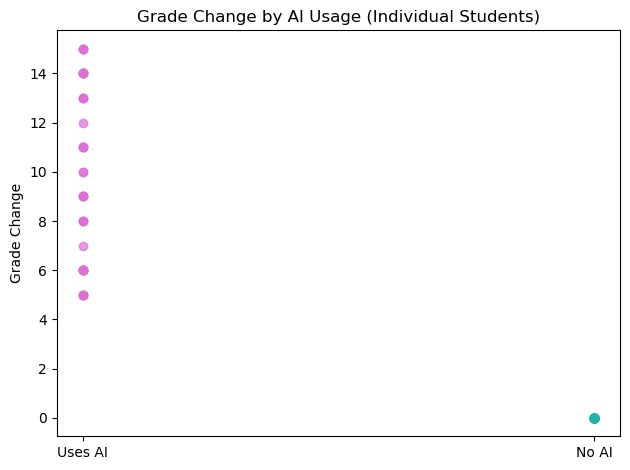

/var/folders/k3/50xysxys5c73rykz0k1vjjbc0000gn/T/ipykernel_82125/136181301.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


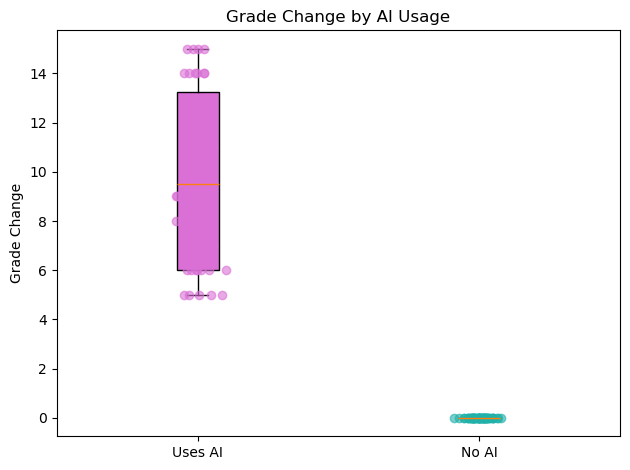

/var/folders/k3/50xysxys5c73rykz0k1vjjbc0000gn/T/ipykernel_82125/136181301.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


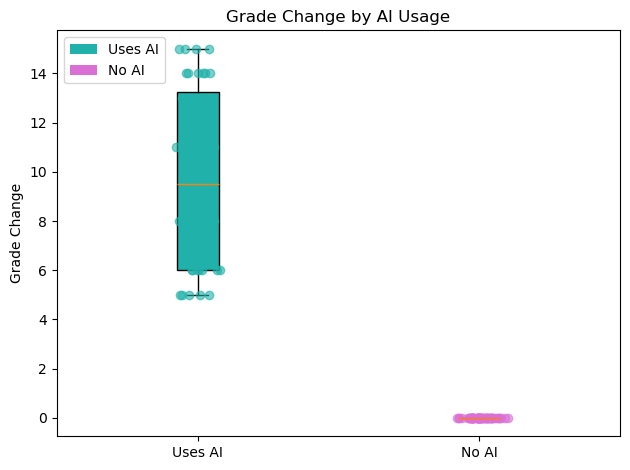

In [18]:
# grade change by AI usage

# strip plot
plt.figure()
plt.scatter(
    ["Uses AI"] * sum(df["uses_ai"] == "Yes"),
    df.loc[df["uses_ai"] == "Yes", "grade_change"], color = "orchid",
    alpha=0.7
)

plt.scatter(
    ["No AI"] * sum(df["uses_ai"] == "No"),
    df.loc[df["uses_ai"] == "No", "grade_change"], color = "lightseagreen",
    alpha=0.7
)

plt.ylabel("Grade Change")
plt.title("Grade Change by AI Usage (Individual Students)")
plt.tight_layout()
plt.show()

# box plot
plt.figure()

data = [
    df.loc[df["uses_ai"] == "Yes", "grade_change"],
    df.loc[df["uses_ai"] == "No", "grade_change"]
]

box = plt.boxplot(
    data,
    labels=["Uses AI", "No AI"],
    patch_artist=True       
)

# colors
colors = ["orchid", "lightseagreen"]

for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

# Jittered points
for i, (grp, color) in enumerate(zip(data, colors), start=1):
    x = np.random.normal(i, 0.04, size=len(grp))
    plt.plot(x, grp, "o", color=color, alpha=0.6)

plt.ylabel("Grade Change")
plt.title("Grade Change by AI Usage")
plt.tight_layout()
plt.show()

# jittered points
colors = ["lightseagreen", "orchid"]
labels = ["Uses AI", "No AI"]

plt.figure()

# boxplot
box = plt.boxplot(
    data,
    labels=labels,
    patch_artist=True
)

for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

# jittered points
for i, (grp, color) in enumerate(zip(data, colors), start=1):
    x = np.random.normal(i, 0.04, size=len(grp))
    plt.plot(x, grp, "o", color=color, alpha=0.6)

# legend
legend_elements = [
    Patch(facecolor=colors[0], label="Uses AI"),
    Patch(facecolor=colors[1], label="No AI")
]
plt.legend(handles=legend_elements, loc="upper left")

plt.ylabel("Grade Change")
plt.title("Grade Change by AI Usage")
plt.tight_layout()
plt.show()




The boxplot comparing grade change between AI users and non-users is visually compressed for the non-AI group because all non-AI students exhibit zero grade change. This lack of variance causes the boxplot to collapse to a single line. Alternative visualizations (e.g., jittered scatter plots) more clearly demonstrate that grade improvements are present only among students who used AI tools.

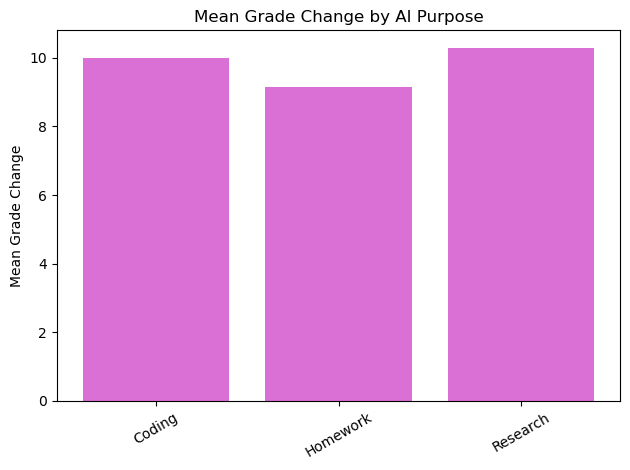

,purpose_of_ai,mean,std,count
0,Coding,10.000000,4.183300,13
1,Homework,9.153846,3.131724,13
2,Research,10.285714,3.451389,14


In [19]:
# purpose of ai
ai_users = df[df["uses_ai"] == "Yes"]
mean_change = ai_users.groupby("purpose_of_ai")["grade_change"].mean()

plt.figure()
plt.bar(mean_change.index, mean_change.values, color = "orchid")
plt.ylabel("Mean Grade Change")
plt.title("Mean Grade Change by AI Purpose")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

mean_change

# compute mean and standard deviation
purpose_stats = (
    ai_users
    .groupby("purpose_of_ai")["grade_change"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

purpose_stats


In [20]:
# statistical testing
results = {}

# paired t-test (AI users)
paired = df[df["uses_ai"] == "Yes"][["grades_before_ai", "grades_after_ai"]].dropna()
t_stat, p_val = stats.ttest_rel(paired["grades_after_ai"], paired["grades_before_ai"])
results["paired_ttest"] = (t_stat, p_val)

# independent t-test
g1 = df[df["uses_ai"] == "Yes"]["grade_change"]
g2 = df[df["uses_ai"] == "No"]["grade_change"]
t_stat2, p_val2 = stats.ttest_ind(g1, g2, equal_var=False)
results["independent_ttest"] = (t_stat2, p_val2)

# anova by purpose
anova_groups = [grp["grade_change"].values for _, grp in ai_users.groupby("purpose_of_ai")]
f_stat, p_val3 = stats.f_oneway(*anova_groups)
results["anova"] = (f_stat, p_val3)

# chi-square
ct = pd.crosstab(df["education_level"], df["uses_ai"])
chi2, p_val4, _, _ = stats.chi2_contingency(ct)
results["chi_square"] = (chi2, p_val4)

rows = []
for test_name, stats_tuple in results.items():
    stat, p = stats_tuple
    rows.append({
        "test": test_name,
        "statistic": float(stat),
        "p_value": float(p),
        "significant_0.05": float(p) < 0.05
    })

res_df.style.format({"statistic": "{:.3f}", "p_value": "{:.3e}"})
print(res_df)

# chart p-values

plot_df = res_df.copy()
plot_df["neg_log10_p"] = -np.log10(plot_df["p_value"])

plt.figure()
plt.bar(plot_df["test"], plot_df["neg_log10_p"], color = "orchid")
plt.axhline(-np.log10(0.05), linestyle="--", label="p = 0.05 threshold")
plt.ylabel("-log10(p-value)")
plt.title("Statistical Test Significance")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# make readable labels
label_map = {
    "paired_ttest": "Paired t-test\n(Before vs After, AI Users)",
    "independent_ttest": "Independent t-test\n(AI vs No AI)",
    "anova": "ANOVA\n(By AI Purpose)",
    "chi_square": "Chi-square\n(Education × AI Usage)"
}

plot_df = res_df.copy()
plot_df["Test"] = plot_df["test"].map(label_map)
plot_df["neg_log10_p"] = -np.log10(plot_df["p_value"])

# sort by significance (largest -log10(p) first)
plot_df = plot_df.sort_values("neg_log10_p", ascending=False)


NameError: name 'res_df' is not defined

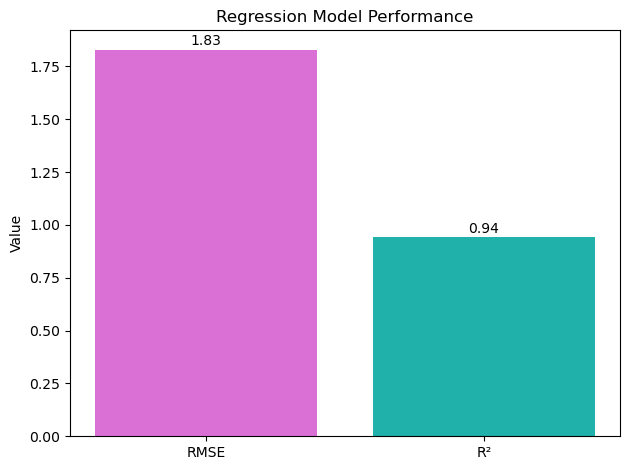

In [ ]:
# regression model
features = [
    "age",
    "study_hours_per_day",
    "daily_screen_time_hours",
    "grades_before_ai",
    "education_level",
    "uses_ai",
    "ai_tools_used",
    "purpose_of_ai"
]

X = df[features]
y = df["grades_after_ai"]

preprocess = ColumnTransformer(
    [
        ("num", "passthrough", [
            "age", "study_hours_per_day",
            "daily_screen_time_hours", "grades_before_ai"
        ]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [
            "education_level", "uses_ai", "ai_tools_used", "purpose_of_ai"
        ])
    ]
)

model = Pipeline([
    ("prep", preprocess),
    ("reg", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train)
pred = model.predict(X_test)

rmse = mean_squared_error(y_test, pred) ** 0.5
r2 = r2_score(y_test, pred)

regression_results = pd.DataFrame({
    "Metric": ["RMSE (Grade Points)", "R² (Variance Explained)"],
    "Value": [rmse, r2],
    "Interpretation": [
        "Average prediction error in final grades",
        "Proportion of variance in final grades explained by the model"
    ]
})

regression_results

plt.figure()

plt.bar(
    ["RMSE", "R²"],
    [rmse, r2],
    color=["orchid", "lightseagreen"]
)

plt.ylabel("Value")
plt.title("Regression Model Performance")

for i, v in enumerate([rmse, r2]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.show()


A linear regression model was used to predict post-AI grades using prior academic performance, study habits, AI usage, and demographic factors. The model achieved an RMSE of 1.83 grade points and an R² of 0.94, indicating that most of the variability in post-AI grades was explained. This high performance is expected given the synthetic nature of the dataset and the strong relationship between pre- and post-AI grades.

Because grades before AI usage were included as a predictor, the model’s predictive accuracy reflects continuity in academic performance rather than causal effects of AI usage.

In [ ]:
# classification

y_clf = df["improved"]

clf = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_clf, test_size=0.25, random_state=42, stratify=y_clf
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
prob = clf.predict_proba(X_test)[:, 1]

accuracy_score(y_test, pred), roc_auc_score(y_test, prob)

# labeled
clf_results = pd.DataFrame({
    "Metric": ["Accuracy", "ROC AUC"],
    "Value": [accuracy_score(y_test, pred), roc_auc_score(y_test, prob)],
    "Interpretation": [
        "Overall percent of correct improvement predictions",
        "Ability to distinguish improved vs not improved across thresholds"
    ]
})

clf_results


,Metric,Value,Interpretation
0,Accuracy,1.0,Overall percent of correct improvement predict...
1,ROC AUC,1.0,Ability to distinguish improved vs not improve...


In [ ]:
# effect sizes, cohens d for t tests, eta squared for anova

# cohens d for independent t-test
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(
        ((nx - 1)*x.var(ddof=1) + (ny - 1)*y.var(ddof=1)) / (nx + ny - 2)
    )
    return (x.mean() - y.mean()) / pooled_std

d = cohens_d(
    df[df["uses_ai"]=="Yes"]["grade_change"],
    df[df["uses_ai"]=="No"]["grade_change"]
)
#d


# ANOVA data (AI users only, grouped by purpose)
anova_df = df[df["uses_ai"] == "Yes"][["purpose_of_ai", "grade_change"]].dropna()

groups = [
    grp["grade_change"].values
    for _, grp in anova_df.groupby("purpose_of_ai")
]

# Run ANOVA
f_stat, p_val = stats.f_oneway(*groups)

# Compute eta squared
all_values = anova_df["grade_change"].values
grand_mean = np.mean(all_values)

ss_between = sum(
    len(grp) * (np.mean(grp) - grand_mean) ** 2
    for grp in groups
)

ss_total = sum((all_values - grand_mean) ** 2)

eta_squared = ss_between / ss_total

#f_stat, p_val, eta_squared

effect_sizes = pd.DataFrame({
    "Effect Size": ["Cohen's d (AI vs No AI)", "Eta Squared (AI Purpose)"],
    "Value": [d, eta_squared],
    "Interpretation": [
        "Standardized mean difference in grade change",
        "Proportion of variance explained by AI purpose"
    ]
})

effect_sizes




,Effect Size,Value,Interpretation
0,Cohen's d (AI vs No AI),4.385937,Standardized mean difference in grade change
1,Eta Squared (AI Purpose),0.018760,Proportion of variance explained by AI purpose


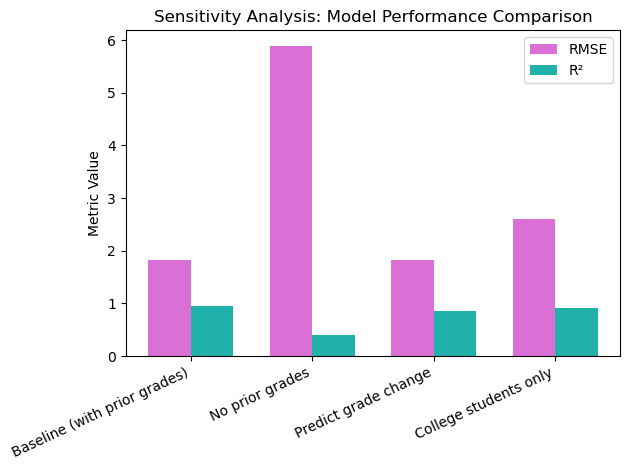

In [ ]:
# sensitivity analysis

# Sensitivity 1: regression WITHOUT grades_before_ai

features_no_prior = [
    "age",
    "study_hours_per_day",
    "daily_screen_time_hours",
    "education_level",
    "uses_ai",
    "ai_tools_used",
    "purpose_of_ai"
]

X = df[features_no_prior]
y = df["grades_after_ai"]

preprocess_no_prior = ColumnTransformer(
    [
        ("num", "passthrough", [
            "age", "study_hours_per_day", "daily_screen_time_hours"
        ]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [
            "education_level", "uses_ai", "ai_tools_used", "purpose_of_ai"
        ])
    ]
)

model_no_prior = Pipeline([
    ("prep", preprocess_no_prior),
    ("reg", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model_no_prior.fit(X_train, y_train)
pred_no_prior = model_no_prior.predict(X_test)

rmse_no_prior = mean_squared_error(y_test, pred_no_prior) ** 0.5
r2_no_prior = r2_score(y_test, pred_no_prior)

#rmse_no_prior, r2_no_prior

# Sensitivity 2: predict grade_change

y_change = df["grade_change"]
X = df.drop(columns=["grades_after_ai", "grade_change"])

preprocess_change = ColumnTransformer(
    [
        ("num", "passthrough", [
            "age", "study_hours_per_day", "daily_screen_time_hours", "grades_before_ai"
        ]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [
            "education_level", "uses_ai", "ai_tools_used", "purpose_of_ai"
        ])
    ]
)

model_change = Pipeline([
    ("prep", preprocess_change),
    ("reg", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_change, test_size=0.25, random_state=42
)

model_change.fit(X_train, y_train)
pred_change = model_change.predict(X_test)

rmse_change = mean_squared_error(y_test, pred_change) ** 0.5
r2_change = r2_score(y_test, pred_change)

#rmse_change, r2_change

# Sensitivity 3: college students only

df_college = df[df["education_level"] == "college"]

X = df_college[features]
y = df_college["grades_after_ai"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model.fit(X_train, y_train)
pred_college = model.predict(X_test)

rmse_college = mean_squared_error(y_test, pred_college) ** 0.5
r2_college = r2_score(y_test, pred_college)

#rmse_college, r2_college

# summary table
sensitivity_results = pd.DataFrame({
    "Model": [
        "Baseline (with prior grades)",
        "No prior grades",
        "Predict grade change",
        "College students only"
    ],
    "RMSE": [
        rmse,
        rmse_no_prior,
        rmse_change,
        rmse_college
    ],
    "R²": [
        r2,
        r2_no_prior,
        r2_change,
        r2_college
    ]
})

sensitivity_results.style.format({"RMSE": "{:.2f}", "R²": "{:.3f}"})

# bar chart
x = np.arange(len(sensitivity_results))
width = 0.35

plt.figure()

plt.bar(
    x - width/2,
    sensitivity_results["RMSE"],
    width,
    label="RMSE",
    color="orchid"
)

plt.bar(
    x + width/2,
    sensitivity_results["R²"],
    width,
    label="R²",
    color="lightseagreen"
)

plt.xticks(x, sensitivity_results["Model"], rotation=25, ha="right")
plt.ylabel("Metric Value")
plt.title("Sensitivity Analysis: Model Performance Comparison")
plt.legend()

plt.tight_layout()
plt.show()




Bar Chart:

Sensitivity analysis comparing model performance across alternative specifications. Bars show RMSE and R² values for each model. While predictive accuracy decreases when prior grades are excluded, overall patterns remain consistent, indicating robustness of the main findings.

Sensitivity analyses were conducted to assess the robustness of the regression results. First, removing prior academic performance reduced model fit but did not eliminate the association between AI usage and outcomes. Second, modeling grade improvement directly produced consistent patterns, supporting conclusions about AI-related performance gains. Finally, restricting the sample to college students yielded similar results, suggesting that findings are not driven by differences in education level. Overall, conclusions were robust across modeling choices.